### Table des matières

* [Introduction](#Introduction)
* [Segmentation des clients par la méthode RFM](#rfm)
* [Classification ascendante hiérarchique :](#cah) 
     * [Dendrogramme](#den)
* [Effectuer un clustering avec la méthode des K-means](#kme)
* [DBSCAN](#dbs)
* [Evaluer la stabilité du Kmeans](#eva)
* [ACP](#acp)
* [Conclusion](#Conclusion)

### Introduction : <a class="anchor" id="Introduction"></a>

- Olist souhaite fournir à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

  L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

- sur ce deuxième notebook nous allons faire une segmentation par différents algorithmes non supervisées afin de fournir àl'équipe marketing une description actionable. Une analyse de stabilité des segments au cours du temps sera réalisée afin d'élaborer un contrat de maintenance.

In [1]:
# Pour le formatage du code pour respecter la convention PEP8
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import plotly.express as px
import datetime as dt

# from datetime import date, timedelta
# Pour les warnings
import warnings

warnings.filterwarnings("ignore")
# Pour les stats
from scipy import stats

# Pour la modélisation
from sklearn.preprocessing import QuantileTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

# from functions import *
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

In [3]:
# Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le plus d'information
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)
pd.set_option("float_format", lambda x: "%.4f" % x)

<IPython.core.display.Javascript object>

In [12]:
# Appel des fonctions
%run functions.py

<IPython.core.display.Javascript object>

In [52]:
df_olist = pd.read_csv(
    "/Users/hananemaghlazi/Desktop/Datascientist/Projets_Formation/P5_MAGHLAZI_Hanane/df_olist.csv"
)

<IPython.core.display.Javascript object>

In [5]:
df_olist.head()

nb_orders  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61 58.9000        13.2900   
1  4244733e06e7ecb4970a6e2683c13e61 55.9000        17.9600   
2  4244733e06e7ecb4970a6e2683c13e61 64.9000        18.3300   
3  4244733e06e7ecb4970a6e2683c13e61 58.9000        16.1700   
4  4244733e06e7ecb4970a6e2683c13e61 58.9000        13.2900   

                        customer_id                customer_unique_id  \
0  3ce436f183e68e07877b285a838db11a  871766c5855e863f6eccc05f988b23cb   
1  e6eecc5a77de221464d1c4eaff0a9b64  0fb8e3eab2d3e79d92bb3fffbb97f188   
2  4ef55bf80f711b372afebcb7c715344a  3419052c8c6b45daf79c1e426f9e9bcb   
3  30407a72ad8b3f4df4d15369126b20c9  e7c828d22c0682c1565252deefbe334d   
4  91a792fef70ecd8cc69d3c7feb3d12da  0bb98ba72dcc08e95f9d8cc434e9a2cc   

  order_purchase_timestamp    order_approved_at order_delivered_carrier_date  \
0      2017-09-13 08:59:02  2017-09-13 09:45:35          2017-09-19 18:34:16   
1      2017-06-28 11:52:20  2017-06-29 02:44:11          2017-07-05 12:00:33   
2      2018-05-18 10:25:53  2018-05-18 12:31:43          2018-05-23 14:05:00   
3      2017-08-01 18:38:42  2017-08-01 18:55:08          2017-08-02 19:07:36   
4      2017-08-10 21:48:40  2017-08-10 22:05:11          2017-08-11 19:43:07   

  date_livraison_recue date_livraison_est  payment_sequential payment_type  \
0  2017-09-20 23:43:48         2017-09-29                   1  credit_card   
1  2017-07-13 20:39:29         2017-07-26                   1       boleto   
2  2018-06-04 18:34:26         2018-06-07                   1  credit_card   
3  2017-08-09 21:26:33         2017-08-25                   1  credit_card   
4  2017-08-24 20:04:21         2017-09-01                   1  credit_card   

   payment_installments  payment_value                         review_id  \
0                     2        72.1900  97ca439bc427b48bc1cd7177abe71365   
1                     1        73.8600  b11cba360bbe71410c291b764753d37f   
2                     2        83.2300  af01c4017c5ab46df6cc810e069e654a   
3                     3        75.0700  8304ff37d8b16b57086fa283fe0c44f8   
4                     4        72.1900  426f43a82185969503fb3c86241a9535   

   review_score product_category_name   %fret  day_diff_achat  
0             5            cool_stuff 18.4098          7.0000  
1             5            cool_stuff 24.3163         15.0000  
2             4            cool_stuff 22.0233         17.0000  
3             5            cool_stuff 21.5399          8.0000  
4             5            cool_stuff 18.4098         13.0000

<IPython.core.display.Javascript object>

In [6]:
summary(df_olist)

Data shape: (112881, 21)
___________________________
Data types:
object     12
float64     5
int64       4
Name: types, dtype: int64
___________________________


types  counts  uniques  nulls  \
%fret                         float64  112881       89      0   
customer_id                    object  112881    94227      0   
customer_unique_id             object  112881    91233      0   
date_livraison_est             object  112881      420      0   
date_livraison_recue           object  112881    93437      0   
day_diff_achat                float64  112881      143      0   
freight_value                 float64  112881     6870      0   
nb_orders                      object  112881    94227      0   
order_approved_at              object  112881    86314      0   
order_delivered_carrier_date   object  112881    78170      0   
order_item_id                   int64  112881       21      0   
order_purchase_timestamp       object  112881      602      0   
order_status                   object  112881        1      0   
payment_installments            int64  112881       23      0   
payment_sequential              int64  112881       26      0   
payment_type                   object  112881        4      0   
payment_value                 float64  112881    28200      0   
price                         float64  112881     5771      0   
product_id                     object  112881    31348      0   
review_id                      object  112881    94052      0   
review_score                    int64  112881        5      0   

                                                           min  
%fret                                                   0.0000  
customer_id                   00012a2ce6f8dcda20d059ce98491703  
customer_unique_id            0000366f3b9a7992bf8c76cfdf3221e2  
date_livraison_est                                  2017-02-01  
date_livraison_recue                       2017-01-11 13:14:05  
day_diff_achat                                          0.0000  
freight_value                                           0.0100  
nb_orders                     00010242fe8c5a6d1ba2dd792cb16214  
order_approved_at                          2017-01-05 12:10:17  
order_delivered_carrier_date               2017-01-06 12:43:41  
order_item_id                                                1  
order_purchase_timestamp                            2017-01-05  
order_status                                         delivered  
payment_installments                                         1  
payment_sequential                                           1  
payment_type                                            boleto  
payment_value                                           0.0000  
price                                                   0.8500  
product_id                    00066f42aeeb9f3007548bb9d3f33c38  
review_id                     0001239bc1de2e33cb583967c2ca4c67  
review_score                                                 1

### Segmentation des clients par la méthode RFM : <a class="anchor" id="rfm"></a>

La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.
Elle permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.
La segmentation RFM prend en compte :
- La Récence (date de la dernière commande)
- La Fréquence des commandes ( la fréquence des achats)
- Le Montant (de la dernière commande ou sur une période donnée) 
 
 pour établir des segments des clients homogènes.

Calculating RFM values :
- La première chose que nous allons calculer est la valeur de récence, le nombre de jours depuis la dernière commande d'un client. Avec cette colonne, nous pouvons savoir quand a été le premier achat et quand a été le dernier achat d'un client.

In [6]:
# J'extraisle jour,date et année
df_olist['order_purchase_timestamp'] = pd.to_datetime(df_olist['order_purchase_timestamp']).dt.date

<IPython.core.display.Javascript object>

In [7]:
# print the time period
print(
    "Min : {}, Max : {}".format(
        min(df_olist.order_purchase_timestamp), max(df_olist.order_purchase_timestamp)
    )
)

Min : 2017-01-05, Max : 2018-08-29


<IPython.core.display.Javascript object>

In [8]:
# pin the last date

pin_date = max(df_olist.order_purchase_timestamp) + dt.timedelta(3)
pin_date

datetime.date(2018, 9, 1)

<IPython.core.display.Javascript object>

In [9]:
# calculate RFM values
# Recency: La date de la dernière commande du client
# Frequency: : La fréquence des achats
# Monetary: Le montant des achats
rfm = df_olist.groupby("customer_unique_id").agg(
    {
        "order_purchase_timestamp": lambda x: (pin_date - x.max()).days,
        "nb_orders": "nunique",
        "payment_value": "sum",
    }
)
# rename the columns
rfm.rename(
    columns={
        "order_purchase_timestamp": "Recency",
        "nb_orders": "Frequency",
        "payment_value": "Monetary",
    },
    inplace=True,
)
rfm.head()

Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      114          1  141.9000
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900
0000f46a3911fa3c0805444483337064      540          1   86.2200
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200
0004aac84e0df4da2b147fca70cf8255      291          1  196.8900

<IPython.core.display.Javascript object>

In [11]:
# Vérification de la distribution des données
rfm.describe()

Recency  Frequency    Monetary
count 91233.0000 91233.0000  91233.0000
mean    238.4098     1.0328    212.2373
std     150.9412     0.2061    631.8035
min       3.0000     1.0000      9.5900
25%     116.0000     1.0000     63.8300
50%     220.0000     1.0000    112.8300
75%     347.0000     1.0000    202.6600
max     604.0000    14.0000 109312.6400

RFM quartiles :
- Je regroupe les clients en fonction des valeurs RFM. 
- J'utilise les valeurs quantiles et les diviser en 4 groupes.

In [10]:
# Calculate quartile values 
quantiles = rfm.quantile(q=[0.25, 0.50, 0.75])
# Transformation en dictionnaire
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 116.0, 0.5: 220.0, 0.75: 347.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.83, 0.5: 112.83, 0.75: 202.66}}

<IPython.core.display.Javascript object>

- Pour la frequence et monetary : ordre décroissant
--> 1 2 3 4 (1 : grosse depenses)
- Pour la récence : ordre croissant

     -  J'ai mis les étiquettes par ordre croissant parce que la récence signifie combien de temps s'est écoulé depuis la dernière commande d'un client donc plus la valeur est petite, plus un client est engagé envers cette marque ( 1 plus récent)

In [13]:
# Appliquer les fonctions pour créer les colonnes quartiles

rfm["R_quartile"] = rfm["Recency"].apply(RScore, args=("Recency", quantiles))
rfm["F_quartile"] = rfm["Frequency"].apply(FMScore, args=("Frequency", quantiles))
rfm["M_quartile"] = rfm["Monetary"].apply(FMScore, args=("Monetary", quantiles))
rfm.head()

Recency  Frequency  Monetary  R_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      114          1  141.9000           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900           2   
0000f46a3911fa3c0805444483337064      540          1   86.2200           4   
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200           3   
0004aac84e0df4da2b147fca70cf8255      291          1  196.8900           3   

                                  F_quartile  M_quartile  
customer_unique_id                                        
0000366f3b9a7992bf8c76cfdf3221e2           4           2  
0000b849f77a49e4a4ce2b2a4ca5be3f           4           4  
0000f46a3911fa3c0805444483337064           4           3  
0000f6ccb0745a6a4b88665a16c9f078           4           4  
0004aac84e0df4da2b147fca70cf8255           4           2

<IPython.core.display.Javascript object>

In [14]:
# Créer colonne segment et score
# Concaténer les trois colonnes de score
rfm["RFM_Segment"] = (
    rfm.R_quartile.map(str) + rfm.F_quartile.map(str) + rfm.M_quartile.map(str)
)
rfm["RFM_Score"] = rfm[["R_quartile", "F_quartile", "M_quartile"]].sum(axis=1)
rfm.head()

Recency  Frequency  Monetary  R_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      114          1  141.9000           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900           2   
0000f46a3911fa3c0805444483337064      540          1   86.2200           4   
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200           3   
0004aac84e0df4da2b147fca70cf8255      291          1  196.8900           3   

                                  F_quartile  M_quartile RFM_Segment  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2           4           2         142   
0000b849f77a49e4a4ce2b2a4ca5be3f           4           4         244   
0000f46a3911fa3c0805444483337064           4           3         443   
0000f6ccb0745a6a4b88665a16c9f078           4           4         344   
0004aac84e0df4da2b147fca70cf8255           4           2         342   

                                  RFM_Score  
customer_unique_id                           
0000366f3b9a7992bf8c76cfdf3221e2          7  
0000b849f77a49e4a4ce2b2a4ca5be3f         10  
0000f46a3911fa3c0805444483337064         11  
0000f6ccb0745a6a4b88665a16c9f078         11  
0004aac84e0df4da2b147fca70cf8255          9

<IPython.core.display.Javascript object>

Regrouper par score et en calculant la moyenne 

In [15]:
# calculate average values for each RFM

rfm_agg = rfm.groupby("RFM_Score").agg(
    {"Recency": "mean", "Frequency": "mean", "Monetary": ["mean", "count"]}
)
rfm_agg.round(1).head()

Recency Frequency Monetary       
              mean      mean     mean  count
RFM_Score                                   
3          61.4000    2.2000 702.9000    497
4         139.7000    2.1000 559.8000    649
5         224.7000    2.1000 491.3000    661
6          90.4000    1.1000 551.7000   5913
7         116.3000    1.0000 338.0000  11231

<IPython.core.display.Javascript object>

RFM_Score sera le score total de l'engagement ou de la fidélité d'un client.
En résumant les trois valeurs, nous pouvons classer les clients en « Gold », « Silver », « Bronze » et « Green».

In [16]:
# assign labels from total score
score_labels = ["Gold", "Silver", "Bronze", "Green"]
score_groups = pd.qcut(rfm.RFM_Score, q=4, labels=score_labels)
rfm["RFM_Level"] = score_groups.values
rfm.head()

Recency  Frequency  Monetary  R_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      114          1  141.9000           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900           2   
0000f46a3911fa3c0805444483337064      540          1   86.2200           4   
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200           3   
0004aac84e0df4da2b147fca70cf8255      291          1  196.8900           3   

                                  F_quartile  M_quartile RFM_Segment  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2           4           2         142   
0000b849f77a49e4a4ce2b2a4ca5be3f           4           4         244   
0000f46a3911fa3c0805444483337064           4           3         443   
0000f6ccb0745a6a4b88665a16c9f078           4           4         344   
0004aac84e0df4da2b147fca70cf8255           4           2         342   

                                  RFM_Score RFM_Level  
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2          7      Gold  
0000b849f77a49e4a4ce2b2a4ca5be3f         10    Bronze  
0000f46a3911fa3c0805444483337064         11     Green  
0000f6ccb0745a6a4b88665a16c9f078         11     Green  
0004aac84e0df4da2b147fca70cf8255          9    Silver

<IPython.core.display.Javascript object>

In [17]:
rfm.loc[(rfm["RFM_Level"] == "Gold")]

Recency  Frequency   Monetary  R_quartile  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2      114          1   141.9000           1   
0004bd2a26a76fe21f786e4fbd80607f      149          1   166.9800           2   
00053a61a98854899e70ed204dd4bafe      185          1   838.3600           2   
0005ef4cd20d2893f0d9fbd94d3c0d97      173          1   129.7600           2   
000e309254ab1fc5ba99dd469d36bdb4       68          1    78.4200           1   
...                                   ...        ...        ...         ...   
fff2ae16b99c6f3c785f0e052f2a9cfb      134          1   200.9000           2   
fff3e1d7bc75f11dc7670619b2e61840       43          1    82.5100           1   
fff5eb4918b2bf4b2da476788d42051c       61          1 17069.7600           1   
fff7219c86179ca6441b8f37823ba3d3      248          1   531.6000           3   
ffff5962728ec6157033ef9805bacc48      122          1   133.6900           2   

                                  F_quartile  M_quartile RFM_Segment  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2           4           2         142   
0004bd2a26a76fe21f786e4fbd80607f           4           2         242   
00053a61a98854899e70ed204dd4bafe           4           1         241   
0005ef4cd20d2893f0d9fbd94d3c0d97           4           2         242   
000e309254ab1fc5ba99dd469d36bdb4           4           3         143   
...                                      ...         ...         ...   
fff2ae16b99c6f3c785f0e052f2a9cfb           4           2         242   
fff3e1d7bc75f11dc7670619b2e61840           4           3         143   
fff5eb4918b2bf4b2da476788d42051c           4           1         141   
fff7219c86179ca6441b8f37823ba3d3           4           1         341   
ffff5962728ec6157033ef9805bacc48           4           2         242   

                                  RFM_Score RFM_Level  
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2          7      Gold  
0004bd2a26a76fe21f786e4fbd80607f          8      Gold  
00053a61a98854899e70ed204dd4bafe          7      Gold  
0005ef4cd20d2893f0d9fbd94d3c0d97          8      Gold  
000e309254ab1fc5ba99dd469d36bdb4          8      Gold  
...                                     ...       ...  
fff2ae16b99c6f3c785f0e052f2a9cfb          8      Gold  
fff3e1d7bc75f11dc7670619b2e61840          8      Gold  
fff5eb4918b2bf4b2da476788d42051c          6      Gold  
fff7219c86179ca6441b8f37823ba3d3          8      Gold  
ffff5962728ec6157033ef9805bacc48          8      Gold  

[35301 rows x 9 columns]

<IPython.core.display.Javascript object>

In [18]:
rfm.loc[(rfm["RFM_Level"] == "Bronze")]

Recency  Frequency  Monetary  R_quartile  \
customer_unique_id                                                           
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900           2   
00050ab1314c0e55a6ca13cf7181fecf      134          1   35.3800           2   
0005e1862207bf6ccc02e4228effd9a0      546          1  150.1200           4   
00090324bbad0e9342388303bb71ba0a      161          1   63.6600           2   
000bfa1d2f1a41876493be685390d6d3      337          1   93.7000           3   
...                                   ...        ...       ...         ...   
ffe4c3aa14d4702fb11fe5b3c4dd755c      464          1  137.3000           4   
ffef0ffa736c7b3d9af741611089729b      460          1  139.0700           4   
fffa431dd3fcdefea4b1777d114144f2      306          1   81.2000           3   
fffb09418989a0dbff854a28163e47c6      258          1   73.1600           3   
fffea47cd6d3cc0a88bd621562a9d061      265          1   84.5800           3   

                                  F_quartile  M_quartile RFM_Segment  \
customer_unique_id                                                     
0000b849f77a49e4a4ce2b2a4ca5be3f           4           4         244   
00050ab1314c0e55a6ca13cf7181fecf           4           4         244   
0005e1862207bf6ccc02e4228effd9a0           4           2         442   
00090324bbad0e9342388303bb71ba0a           4           4         244   
000bfa1d2f1a41876493be685390d6d3           4           3         343   
...                                      ...         ...         ...   
ffe4c3aa14d4702fb11fe5b3c4dd755c           4           2         442   
ffef0ffa736c7b3d9af741611089729b           4           2         442   
fffa431dd3fcdefea4b1777d114144f2           4           3         343   
fffb09418989a0dbff854a28163e47c6           4           3         343   
fffea47cd6d3cc0a88bd621562a9d061           4           3         343   

                                  RFM_Score RFM_Level  
customer_unique_id                                     
0000b849f77a49e4a4ce2b2a4ca5be3f         10    Bronze  
00050ab1314c0e55a6ca13cf7181fecf         10    Bronze  
0005e1862207bf6ccc02e4228effd9a0         10    Bronze  
00090324bbad0e9342388303bb71ba0a         10    Bronze  
000bfa1d2f1a41876493be685390d6d3         10    Bronze  
...                                     ...       ...  
ffe4c3aa14d4702fb11fe5b3c4dd755c         10    Bronze  
ffef0ffa736c7b3d9af741611089729b         10    Bronze  
fffa431dd3fcdefea4b1777d114144f2         10    Bronze  
fffb09418989a0dbff854a28163e47c6         10    Bronze  
fffea47cd6d3cc0a88bd621562a9d061         10    Bronze  

[16948 rows x 9 columns]

<IPython.core.display.Javascript object>

In [19]:
rfm.loc[(rfm['RFM_Level'] == "Green")]

Recency  Frequency  Monetary  R_quartile  \
customer_unique_id                                                           
0000f46a3911fa3c0805444483337064      540          1   86.2200           4   
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200           3   
0006fdc98a402fceb4eb0ee528f6a8d4      410          1   29.0000           4   
000a5ad9c4601d2bbdd9ed765d5213b3      386          1   91.2800           4   
000c8bdb58a29e7115cfc257230fb21b      263          1   29.0000           3   
...                                   ...        ...       ...         ...   
fff1afc79f6b5db1e235a4a6c30ceda7      367          1   50.0900           4   
fff3a9369e4b7102fab406a334a678c3      386          1  102.7400           4   
fff699c184bcc967d62fa2c6171765f7      365          1   55.0000           4   
ffff371b4d645b6ecea244b27531430a      571          1  112.4600           4   
ffffd2657e2aad2907e67c3e9daecbeb      487          1   71.5600           4   

                                  F_quartile  M_quartile RFM_Segment  \
customer_unique_id                                                     
0000f46a3911fa3c0805444483337064           4           3         443   
0000f6ccb0745a6a4b88665a16c9f078           4           4         344   
0006fdc98a402fceb4eb0ee528f6a8d4           4           4         444   
000a5ad9c4601d2bbdd9ed765d5213b3           4           3         443   
000c8bdb58a29e7115cfc257230fb21b           4           4         344   
...                                      ...         ...         ...   
fff1afc79f6b5db1e235a4a6c30ceda7           4           4         444   
fff3a9369e4b7102fab406a334a678c3           4           3         443   
fff699c184bcc967d62fa2c6171765f7           4           4         444   
ffff371b4d645b6ecea244b27531430a           4           3         443   
ffffd2657e2aad2907e67c3e9daecbeb           4           3         443   

                                  RFM_Score RFM_Level  
customer_unique_id                                     
0000f46a3911fa3c0805444483337064         11     Green  
0000f6ccb0745a6a4b88665a16c9f078         11     Green  
0006fdc98a402fceb4eb0ee528f6a8d4         12     Green  
000a5ad9c4601d2bbdd9ed765d5213b3         11     Green  
000c8bdb58a29e7115cfc257230fb21b         11     Green  
...                                     ...       ...  
fff1afc79f6b5db1e235a4a6c30ceda7         12     Green  
fff3a9369e4b7102fab406a334a678c3         11     Green  
fff699c184bcc967d62fa2c6171765f7         12     Green  
ffff371b4d645b6ecea244b27531430a         11     Green  
ffffd2657e2aad2907e67c3e9daecbeb         11     Green  

[17137 rows x 9 columns]

In [19]:
# calculate average values for each RFM level

rfm_agg_level = rfm.groupby('RFM_Level').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg_level.round(1).head()

Recency Frequency Monetary       
              mean      mean     mean  count
RFM_Level                                   
Gold      137.6000    1.1000 352.0000  35301
Silver    235.1000    1.0000 200.8000  21847
Bronze    296.2000    1.0000  91.8000  16948
Green     393.1000    1.0000  58.0000  17137

<IPython.core.display.Javascript object>

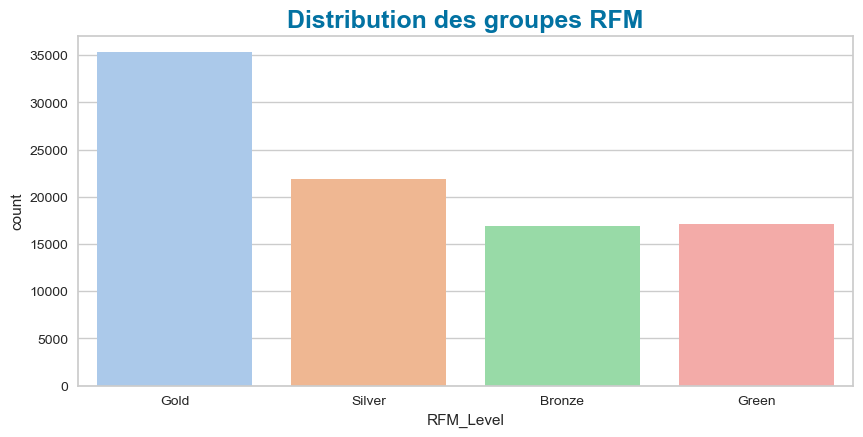

<IPython.core.display.Javascript object>

In [20]:
# Plotting countplot of clusters
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
pl = sns.countplot(x=rfm["RFM_Level"], palette="pastel")
pl.set_title("Distribution des groupes RFM", fontsize=18, color="b", fontweight="bold")
plt.show()

Des groupes bien répartis :

In [21]:
# Visualiser les différents level des clients

rfm_agg_level_mean = rfm.groupby("RFM_Level")["Recency", "Frequency", "Monetary"].mean()
rfm_agg_level_mean.reset_index(inplace=True)
fig = px.scatter_3d(
    rfm_agg_level_mean, x="Recency", y="Frequency", z="Monetary", color="RFM_Level"
)
fig.show()

<IPython.core.display.Javascript object>

[]

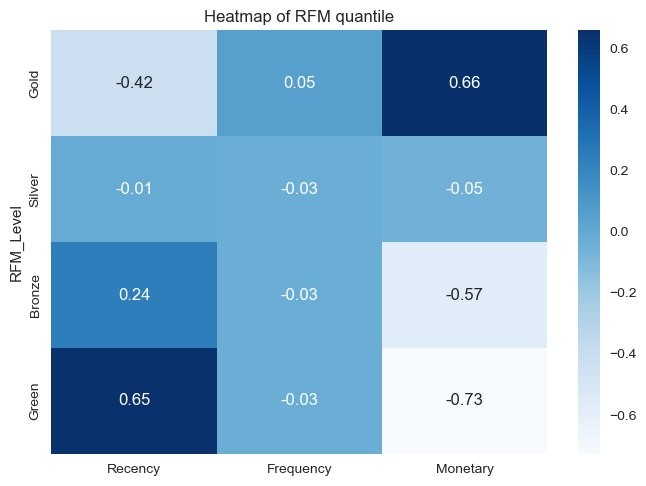

<IPython.core.display.Javascript object>

In [22]:
# the mean value in total
total_avg = rfm.iloc[:, 0:3].mean()
total_avg
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby("RFM_Level").mean().iloc[:, 0:3]
prop_rfm = cluster_avg / total_avg - 1
# heatmap with RFM
sns.heatmap(prop_rfm, cmap="Blues", fmt=".2f", annot=True)
plt.title("Heatmap of RFM quantile")
plt.plot()

- Définition métier des groupes définis par la méthode RFM :

Presque la meme frequence pour tous les groupes ( normal vu le dateset dont 97% des cleints ont commandé une seule fois et que 3% en aceter plus d'un article)

- Gold : Ce groupe regroupe 35301 clients qui ont fait les plus gros achats, et qui ont acheté le plus récemment (Champions)
Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.

- Silver : Ce groupe regroupe 21847 clients , ils dépensent beaucoup, ils n'ont pas acheté récemment (Clients à risque)
Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.

- Bronze : Ce groupe regroupe 16948 clients , font des achats moyens et n'ont pas acheté récemment (Clients sur le point de s’endormir)
Partagez-leur des ressources de valeur, recommandez-leur des produits populaires, des promotions sur leur renouvellement. Reconnectez avec eux.

- Green : Ce groupe regroupe 17137 clients , ils font peu d'achats et n'ont pas acheté depuis longtemps (Clients perdus	)
Essayez de réveiller leur intérêt avec une campagne

###   - Effectuer un clustering avec :
 -  Dendrogramme
 -  Méthode des K-means

Création du dataframe pour le clustering : 
Integration des variables choisis lors de l'analyse

In [23]:
df_olist[df_olist["customer_unique_id"] == "00e5dfd6ee7406a69b74c72795e6f354"]

nb_orders  order_item_id  \
43046  3ac5f81cae4e0191f17d05323fb9ce6f              1   

                             product_id   price  freight_value  \
43046  205cf43d203186d5eb440a791a5b7404 29.9900        14.1000   

                            customer_id                customer_unique_id  \
43046  1ec8756699bd9918239bce55e91a4421  00e5dfd6ee7406a69b74c72795e6f354   

      order_purchase_timestamp    order_approved_at  \
43046               2017-12-30  2017-12-31 21:07:00   

      order_delivered_carrier_date date_livraison_recue date_livraison_est  \
43046          2018-01-05 22:20:45  2018-01-09 14:59:08         2018-02-01   

       payment_sequential payment_type  payment_installments  payment_value  \
43046                   1  credit_card                     2        44.0900   

                              review_id  review_score product_category_name  \
43046  0466cf95611dfc1f38a0aa139004f449             3                  baby   

        %fret  day_diff_achat  
43046 31.9800          9.0000

<IPython.core.display.Javascript object>

In [24]:
# Aggéger le dataframe avec les variables selectionnées
df_olist_2 = df_olist.groupby("customer_unique_id").agg(
    {
        "order_purchase_timestamp": lambda x: (pin_date - x.max()).days,
        "nb_orders": "nunique",
        "payment_value": "sum",
        "review_score": "mean",
        "payment_installments": "mean",
        "payment_sequential": "mean",
        "%fret": "mean",
        "day_diff_achat": "mean",
    }
)
# rename the columns
df_olist_2.rename(
    columns={
        "order_purchase_timestamp": "Recency",
        "nb_orders": "Frequency",
        "payment_value": "Monetary",
        "review_score": "Score_moyen",
        "payment_installments": "Nb_Versement",
        "payment_sequential": "Moyen_paiement",
        "%fret": "Fret_moyen",
    },
    inplace=True,
)
df_olist_2.head()

Recency  Frequency  Monetary  Score_moyen  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2      114          1  141.9000       5.0000   
0000b849f77a49e4a4ce2b2a4ca5be3f      117          1   27.1900       4.0000   
0000f46a3911fa3c0805444483337064      540          1   86.2200       3.0000   
0000f6ccb0745a6a4b88665a16c9f078      324          1   43.6200       4.0000   
0004aac84e0df4da2b147fca70cf8255      291          1  196.8900       5.0000   

                                  Nb_Versement  Moyen_paiement  Fret_moyen  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2        8.0000          1.0000      8.4567   
0000b849f77a49e4a4ce2b2a4ca5be3f        1.0000          1.0000     30.4892   
0000f46a3911fa3c0805444483337064        8.0000          1.0000     19.9722   
0000f6ccb0745a6a4b88665a16c9f078        4.0000          1.0000     40.4172   
0004aac84e0df4da2b147fca70cf8255        6.0000          1.0000      8.5784   

                                  day_diff_achat  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2          6.0000  
0000b849f77a49e4a4ce2b2a4ca5be3f          3.0000  
0000f46a3911fa3c0805444483337064         25.0000  
0000f6ccb0745a6a4b88665a16c9f078         20.0000  
0004aac84e0df4da2b147fca70cf8255         13.0000

<IPython.core.display.Javascript object>

In [21]:
# Vérification de la distribution
df_olist_2.describe()

Recency  Frequency    Monetary  Score_moyen  Nb_Versement  \
count 91233.0000 91233.0000  91233.0000   91233.0000    91233.0000   
mean    238.4098     1.0328    212.2373       4.1553        2.9011   
std     150.9412     0.2061    631.8035       1.2787        2.6783   
min       3.0000     1.0000      9.5900       1.0000        1.0000   
25%     116.0000     1.0000     63.8300       4.0000        1.0000   
50%     220.0000     1.0000    112.8300       5.0000        2.0000   
75%     347.0000     1.0000    202.6600       5.0000        4.0000   
max     604.0000    14.0000 109312.6400       5.0000       24.0000   

       Moyen_paiement  Fret_moyen  day_diff_achat  
count      91233.0000  91233.0000      91233.0000  
mean           1.0228     20.8975         12.0376  
std            0.1846     12.4802          9.4465  
min            1.0000      0.0000          0.0000  
25%            1.0000     12.0000          6.0000  
50%            1.0000     18.0000         10.0000  
75%            1.0000     28.0000         15.0000  
max           13.5000     96.0000        208.0000

Par conséquent, en ce qui concerne le clustering K-means et le CAH, la mise à l'échelle et la normalisation des données est une étape critique pour le prétraitement. Si nous vérifions la distribution des valeurs RFM, vous pouvez remarquer qu'elles sont asymétriques à droite. Ce n'est pas un bon état à utiliser sans normalisation. Transformons d'abord les valeurs RFM en échelle logarithmique, puis normalisons-les.

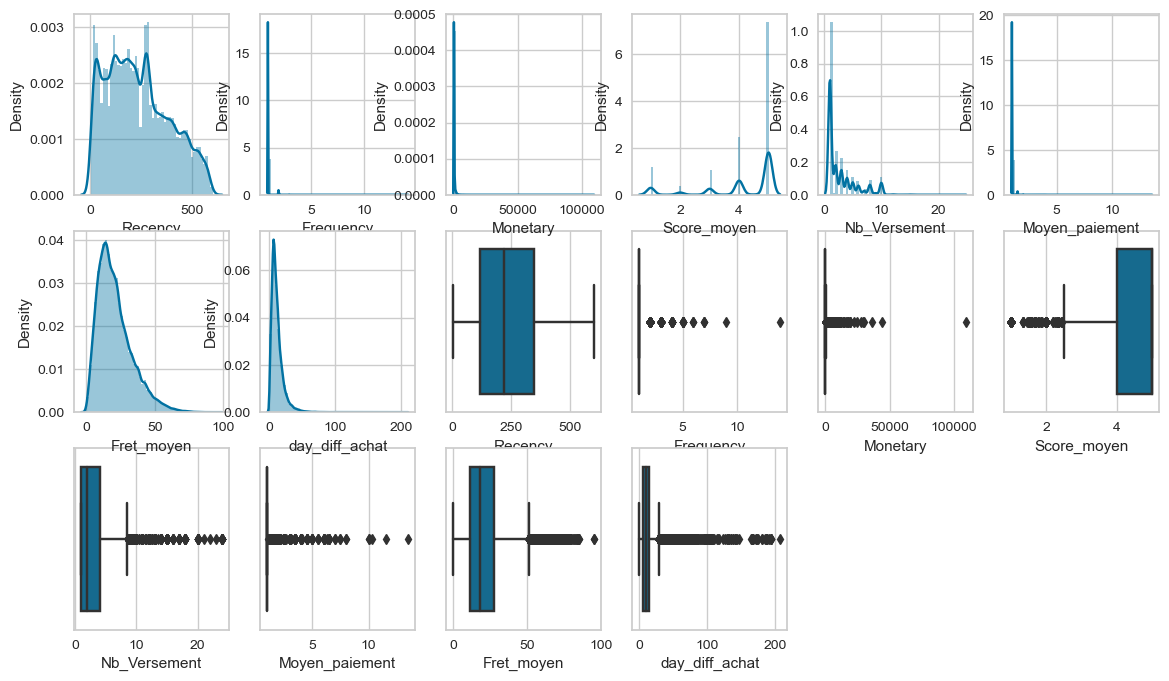

<IPython.core.display.Javascript object>

In [25]:
# Plotting RFM distributions

col = [
    "Recency",
    "Frequency",
    "Monetary",
    "Score_moyen",
    "Nb_Versement",
    "Moyen_paiement",
    "Fret_moyen",
    "day_diff_achat",
]
# Distribution des variables à prédire
fig = plt.figure(1, figsize=(14, 8))
for i, label in enumerate(col):

    plt.subplot(3, 6, i + 1)
    sns.distplot(df_olist_2[label])
    plt.subplot(3, 6, i + 9)
    sns.boxplot(df_olist_2[label])
plt.show()

Une distribution asymétrique et présence d'outliers

In [26]:
df_olist_2[df_olist_2["Monetary"] > 100000]

Recency  Frequency    Monetary  Score_moyen  \
customer_unique_id                                                              
0a0a92112bd4c708ca5fde585afaa872      337          1 109312.6400       1.0000   

                                  Nb_Versement  Moyen_paiement  Fret_moyen  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872        1.0000          1.0000      1.6399   

                                  day_diff_achat  
customer_unique_id                                
0a0a92112bd4c708ca5fde585afaa872         18.0000

<IPython.core.display.Javascript object>

In [27]:
df_olist[df_olist["customer_unique_id"] == "0a0a92112bd4c708ca5fde585afaa872"]

nb_orders  order_item_id  \
87484  03caa2c082116e1d31e67e9ae3700499              1   
87485  03caa2c082116e1d31e67e9ae3700499              2   
87486  03caa2c082116e1d31e67e9ae3700499              3   
87487  03caa2c082116e1d31e67e9ae3700499              4   
87488  03caa2c082116e1d31e67e9ae3700499              5   
87489  03caa2c082116e1d31e67e9ae3700499              6   
87490  03caa2c082116e1d31e67e9ae3700499              7   
87491  03caa2c082116e1d31e67e9ae3700499              8   

                             product_id     price  freight_value  \
87484  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87485  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87486  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87487  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87488  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87489  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87490  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   
87491  5769ef0a239114ac3a854af00df129e4 1680.0000        28.0100   

                            customer_id                customer_unique_id  \
87484  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87485  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87486  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87487  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87488  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87489  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87490  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   
87491  1617b1357756262bfa56ab541c47bc16  0a0a92112bd4c708ca5fde585afaa872   

      order_purchase_timestamp    order_approved_at  \
87484               2017-09-29  2017-10-02 15:28:20   
87485               2017-09-29  2017-10-02 15:28:20   
87486               2017-09-29  2017-10-02 15:28:20   
87487               2017-09-29  2017-10-02 15:28:20   
87488               2017-09-29  2017-10-02 15:28:20   
87489               2017-09-29  2017-10-02 15:28:20   
87490               2017-09-29  2017-10-02 15:28:20   
87491               2017-09-29  2017-10-02 15:28:20   

      order_delivered_carrier_date date_livraison_recue date_livraison_est  \
87484          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87485          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87486          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87487          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87488          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87489          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87490          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   
87491          2017-10-10 15:43:17  2017-10-17 18:22:29         2017-10-23   

       payment_sequential payment_type  payment_installments  payment_value  \
87484                   1  credit_card                     1     13664.0800   
87485                   1  credit_card                     1     13664.0800   
87486                   1  credit_card                     1     13664.0800   
87487                   1  credit_card                     1     13664.0800   
87488                   1  credit_card                     1     13664.0800   
87489                   1  credit_card                     1     13664.0800   
87490                   1  credit_card                     1     13664.0800   
87491                   1  credit_card                     1     13664.0800   

                              review_id  review_score product_category_name  \
87484  211fa81a22870cc634265ea85b751e40             1       fixed_telephony   
87485  211fa81a22870cc634265ea85b751e40             1       fixed_telephony   
87486  211fa81a22870cc634265ea85b751e40             

<IPython.core.display.Javascript object>

La vérification de la distribution a montré des valeurs min à 0 je les remplace par 1

In [28]:
df_olist_2["Fret_moyen"] = [neg_to_zero(x) for x in df_olist_2.Fret_moyen]
df_olist_2["day_diff_achat"] = [neg_to_zero(x) for x in df_olist_2.day_diff_achat]

<IPython.core.display.Javascript object>

les distributions sont asymétriques ce qui écrasent les boxplot
Présence d'outliers
J''utilise un quintile transformer : Cette méthode transforme les caractéristiques pour suivre une distribution normale. Ainsi, pour une caractéristique donnée, cette transformation tend à étaler les valeurs les plus fréquentes. Il réduit également l'impact des valeurs aberrantes : il s'agit donc d'un schéma de prétraitement robuste.

In [29]:
qt = QuantileTransformer(n_quantiles=900, random_state=42)
df_olist_2_scaled = qt.fit_transform(df_olist_2)

# transform into a dataframe
df_olist_2_scaled = pd.DataFrame(
    df_olist_2_scaled, index=df_olist_2.index, columns=df_olist_2.columns
)
df_olist_2_scaled.head()

Recency  Frequency  Monetary  Score_moyen  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2   0.2436     0.0000    0.6051       1.0000   
0000b849f77a49e4a4ce2b2a4ca5be3f   0.2536     0.0000    0.0218       0.3109   
0000f46a3911fa3c0805444483337064   0.9683     0.0000    0.3818       0.1691   
0000f6ccb0745a6a4b88665a16c9f078   0.7175     0.0000    0.1216       0.3109   
0004aac84e0df4da2b147fca70cf8255   0.6669     0.0000    0.7406       1.0000   

                                  Nb_Versement  Moyen_paiement  Fret_moyen  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2        0.9188          0.0000      0.1345   
0000b849f77a49e4a4ce2b2a4ca5be3f        0.0000          0.0000      0.8040   
0000f46a3911fa3c0805444483337064        0.9188          0.0000      0.5514   
0000f6ccb0745a6a4b88665a16c9f078        0.7531          0.0000      0.9183   
0004aac84e0df4da2b147fca70cf8255        0.8621          0.0000      0.1391   

                                  day_diff_achat  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2          0.2347  
0000b849f77a49e4a4ce2b2a4ca5be3f          0.0684  
0000f46a3911fa3c0805444483337064          0.9255  
0000f6ccb0745a6a4b88665a16c9f078          0.8637  
0004aac84e0df4da2b147fca70cf8255          0.6657

<IPython.core.display.Javascript object>

In [24]:
df_olist_2_scaled.describe()

Recency  Frequency   Monetary  Score_moyen  Nb_Versement  \
count 91233.0000 91233.0000 91233.0000   91233.0000    91233.0000   
mean      0.5000     0.0291     0.5000       0.6681        0.3830   
std       0.2887     0.1668     0.2887       0.4045        0.3855   
min       0.0000     0.0000     0.0000       0.0000        0.0000   
25%       0.2503     0.0000     0.2500       0.3109        0.0000   
50%       0.5000     0.0000     0.5000       1.0000        0.5501   
75%       0.7503     0.0000     0.7501       1.0000        0.7531   
max       1.0000     1.0000     1.0000       1.0000        1.0000   

       Moyen_paiement  Fret_moyen  day_diff_achat  
count      91233.0000  91233.0000      91233.0000  
mean           0.0305      0.5000          0.4999  
std            0.1706      0.2886          0.2885  
min            0.0000      0.0000          0.0000  
25%            0.0000      0.2597          0.2347  
50%            0.0000      0.4872          0.5122  
75%            0.0000      0.7508          0.7453  
max            1.0000      1.0000          1.0000

Visualisation après standarisation

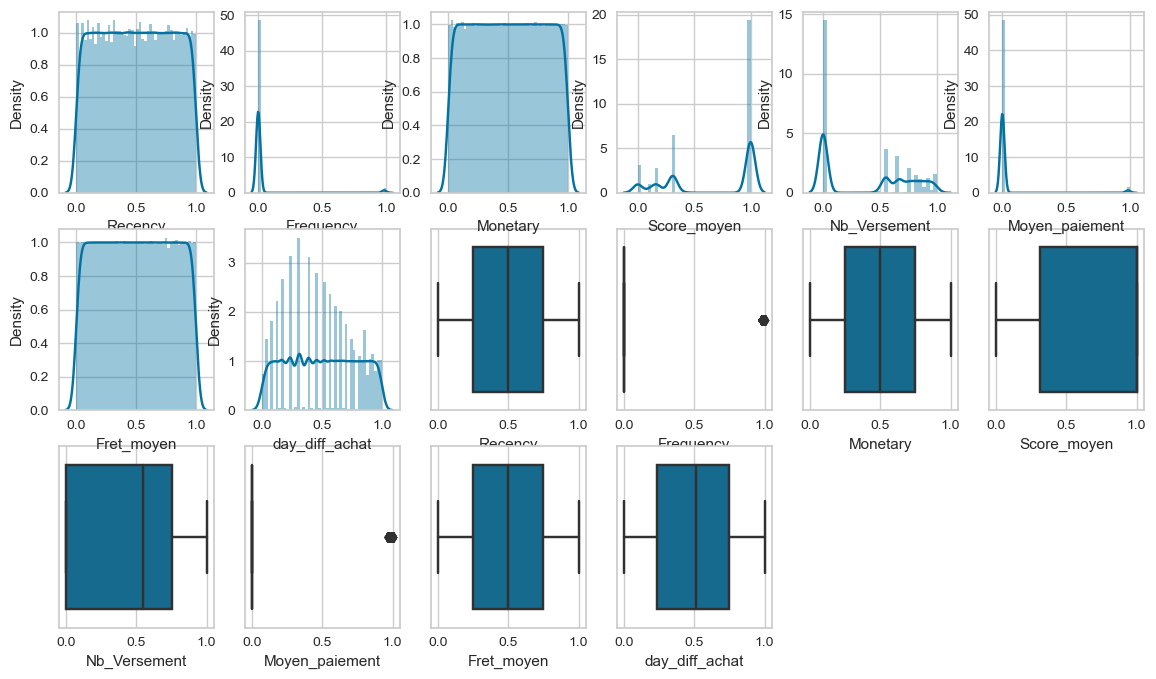

<IPython.core.display.Javascript object>

In [30]:
# Plotting distributions after transformation

col = [
    "Recency",
    "Frequency",
    "Monetary",
    "Score_moyen",
    "Nb_Versement",
    "Moyen_paiement",
    "Fret_moyen",
    "day_diff_achat",
]
# Distribution des variables à prédire
fig = plt.figure(1, figsize=(14, 8))
for i, label in enumerate(col):

    plt.subplot(3, 6, i + 1)
    sns.distplot(df_olist_2_scaled[label])
    plt.subplot(3, 6, i + 9)
    sns.boxplot(df_olist_2_scaled[label])
plt.show()

### Classification ascendante hiérarchique :  <a class="anchor" id="cah"></a>

#### Dendrogramme : <a class="anchor" id="den"></a>

 -  Dendrogramme : 
 CAH : on considère tout d'abord que chaque point est un cluster. Il y a donc autant de clusters que de points. Ensuite, on cherche les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points soient regroupés en un seul grand cluster. Que ce soit avec l'approche ascendante ou descendante, on a besoin de mesurer la distance entre 2 clusters. Le lien centroïdal : on considère que la distance entre 2 clusters est la distance entre les centroïdes de ceux-ci.

In [31]:
# J'extrais un échantillon :
df_olist_2_sample = df_olist_2.sample(frac=0.5).round(3)
df_olist_2_sample.shape

(45616, 8)

<IPython.core.display.Javascript object>

In [32]:
qt = QuantileTransformer(n_quantiles=900, random_state=42)
df_olist_2_sample_scaled = qt.fit_transform(df_olist_2_sample)


# transform into a dataframe
df_olist_2_sample_scaled = pd.DataFrame(
    df_olist_2_sample_scaled,
    index=df_olist_2_sample.index,
    columns=df_olist_2_sample.columns,
)
df_olist_2_sample_scaled.head()

Recency  Frequency  Monetary  Score_moyen  \
customer_unique_id                                                            
72ff384d757b9a86b989214e8801b21f   0.0061     0.0000    0.9846       0.3103   
242d9d689ccba1d338ab7e40ebb20dec   0.7848     0.0000    0.6972       0.1685   
faa5d8e4fbf010ed7edfeb258c7ae0d4   0.7875     0.0000    0.7820       1.0000   
4fd3a2b66fae1c2e6ef8b82bb7de0f8b   0.6396     0.0000    0.8365       0.1685   
da6c55997d0309214cba42a738d50cc0   0.8059     0.0000    0.7549       1.0000   

                                  Nb_Versement  Moyen_paiement  Fret_moyen  \
customer_unique_id                                                           
72ff384d757b9a86b989214e8801b21f        0.0000          0.0000      0.1469   
242d9d689ccba1d338ab7e40ebb20dec        0.5495          0.0000      0.3705   
faa5d8e4fbf010ed7edfeb258c7ae0d4        0.8159          0.0000      0.1237   
4fd3a2b66fae1c2e6ef8b82bb7de0f8b        0.0000          0.0000      0.2158   
da6c55997d0309214cba42a738d50cc0        0.0000          0.0000      0.1160   

                                  day_diff_achat  
customer_unique_id                                
72ff384d757b9a86b989214e8801b21f          0.1685  
242d9d689ccba1d338ab7e40ebb20dec          0.9321  
faa5d8e4fbf010ed7edfeb258c7ae0d4          0.4499  
4fd3a2b66fae1c2e6ef8b82bb7de0f8b          0.8448  
da6c55997d0309214cba42a738d50cc0          0.7442

<IPython.core.display.Javascript object>

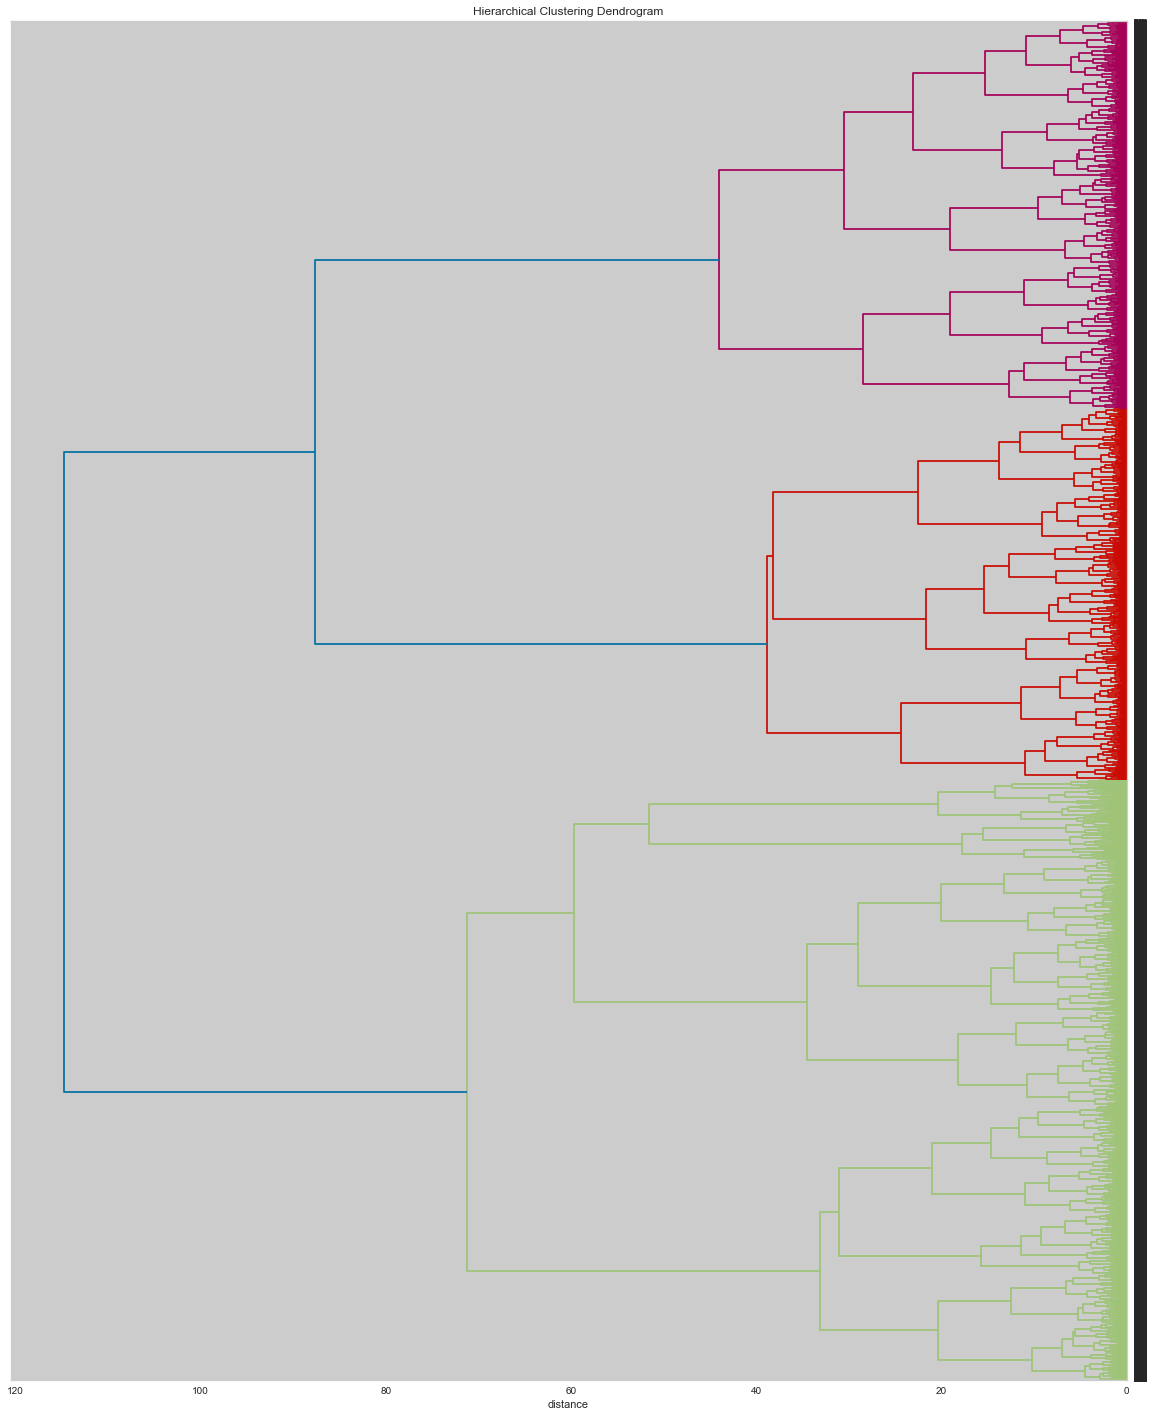

In [78]:
# Clustering hiérarchique
Z = linkage(df_olist_2_sample_scaled, 'ward')
# Affichage du dendrogramme en appelant la fonction
plot_dendrogram(Z)

Le dendrograme suggère un découpage sur trois groupes

###  Effectuer un clustering avec la méthode des K-means : <a class="anchor" id="kme"></a>

Kmeans : C'est un type d'algorithmes d'apprentissage non supervisé, qui crée des groupes en fonction de la distance entre les points. Comment? Il existe deux concepts de distance dans le clustering K-Means. Dans les sommes des carrés des clusters (WSS) et entre les sommes des carrés des clusters (BSS).

- Choisir le nombre de clustering : 
- Elbow method : Elle consiste à calculer la variance des différents volumes de clusters envisagés, puis à placer les variances obtenues sur un graphique. On obtient alors une visualisation en forme de coude 

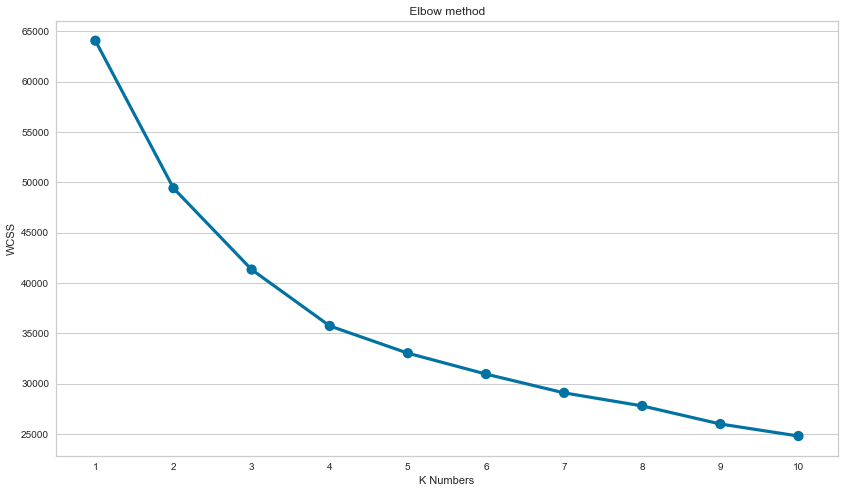

In [62]:
# the Elbow method
wcss = {}
fig = plt.figure(1, figsize=(14, 8))
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init= 'k-means++', max_iter = 300)
    kmeans.fit(df_olist_2_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.title(" Elbow method ")
plt.show()

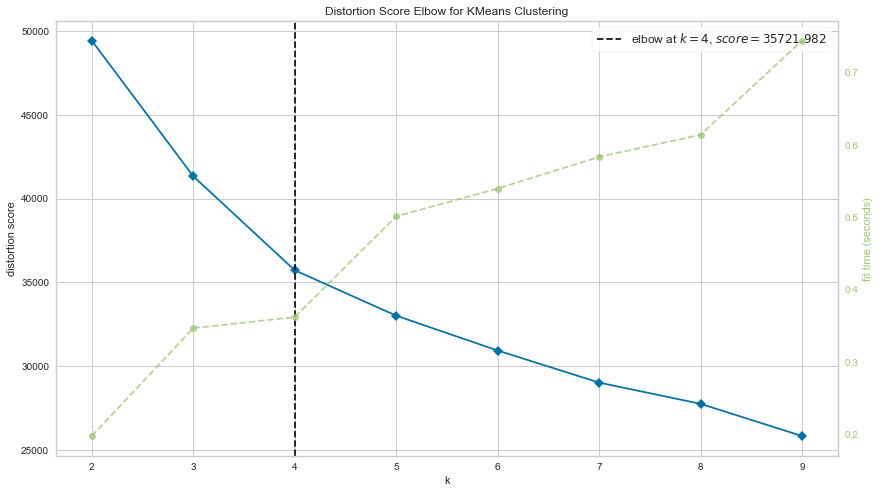

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
fig = plt.figure(1, figsize=(14, 8))

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k =(2,10),random_state = 42)

# Fit the data to the visualizer
visualizer.fit(df_olist_2_scaled)

# Draw/show/poof the data
visualizer.poof()   

Avec la visualisation la méthode du coude indique bien 4 clusters

- Calcul du coefficient de silhouette : 

L'analyse de silhouette peut être utilisée pour évaluer la densité et la séparation entre les clusters. Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui est calculé comme la différence entre la distance moyenne intra-grappe et la distance moyenne de la grappe la plus proche pour chaque échantillon, normalisée par la valeur maximale

Text(0.5, 1.0, 'Calcul du coefficielnt de silhouette')

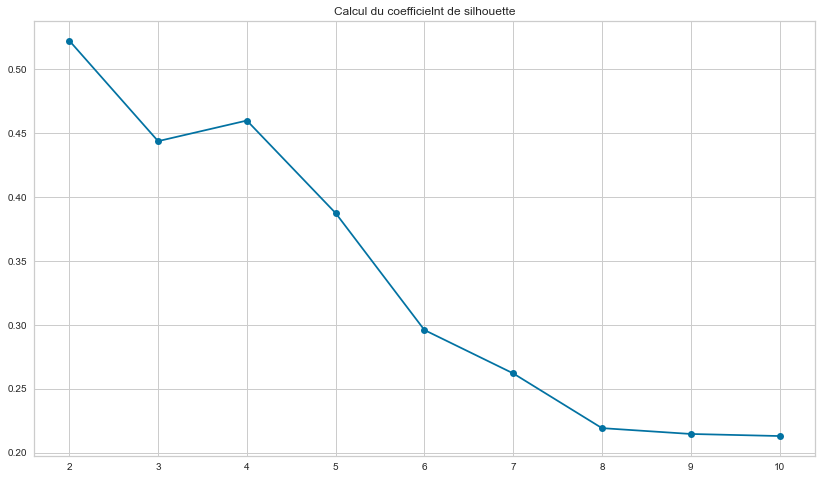

In [65]:
fig = plt.figure(1, figsize=(14, 8))

silhouettes = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300, random_state=42)
    kmeans.fit(df_olist_2_scaled)
    silh= metrics.silhouette_score(df_olist_2_scaled, kmeans.labels_)
    silhouettes.append(silh)
plt.plot(range(2,11), silhouettes, marker='o')
plt.title("Calcul du coefficielnt de silhouette")

Le coefficient de silhouette décroit avec le nombre de cluster, il  remonte pour le nombre 2 et 4 
Le nombre de cluster indique 2 ou 4 clusters , le nombre pour lequel le coefficient de silhouette est plus élevé

Visualisation des clusters 

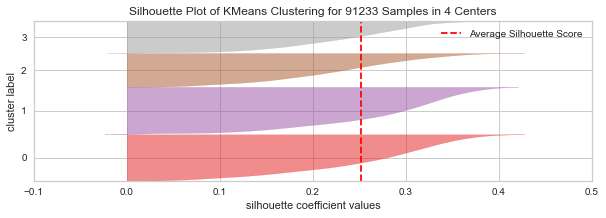

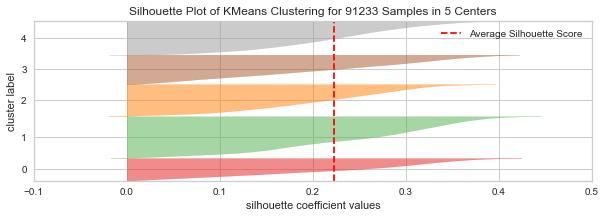

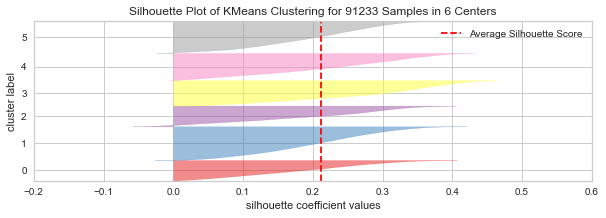

<Figure size 576x396 with 0 Axes>

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
visualizers(df_olist_2_scaled, 4)

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
visualizers(df_olist_2_scaled, 5)

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
visualizers(df_olist_2_scaled, 6)

plt.tight_layout()

- Lancer un kmeans pour les comparaisons : 4 / 5 avec visualisation

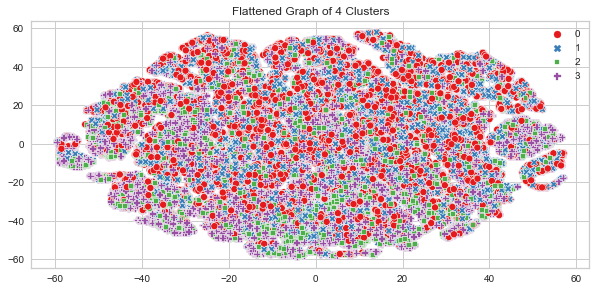

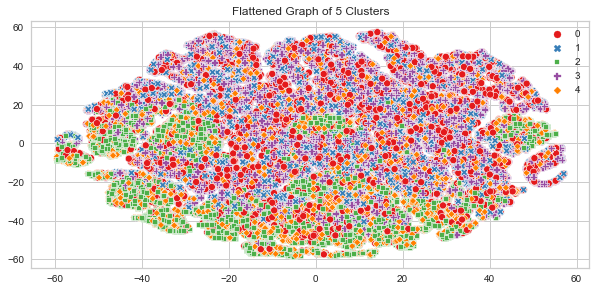

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
df_k4 = kmeans(df_olist_2_scaled, 4, df_olist_2)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
df_k5 = kmeans(df_olist_2_scaled, 5, df_olist_2)

visuellement le clustering avec 4 est mieux séparé

Je visualise par snake plot

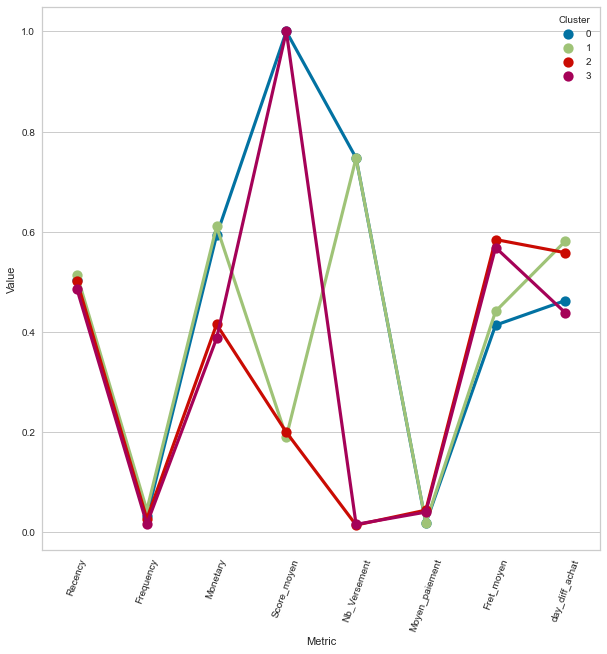

In [37]:
plt.figure(figsize=(10, 10))

snake_plot(df_olist_2_scaled,df_k4,df_olist_2)

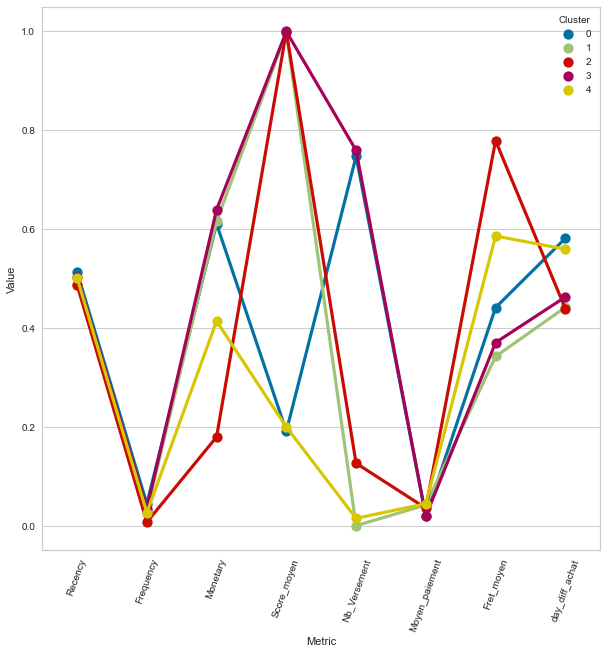

In [38]:
plt.figure(figsize=(10, 10))
snake_plot(df_olist_2_scaled,df_k5,df_olist_2)

In [39]:
k_values(df_k4)

Recency Frequency Monetary Score_moyen Nb_Versement Moyen_paiement  \
            mean      mean     mean        mean         mean           mean   
Cluster                                                                       
0       241.2630    1.0360 243.9840      5.0000       4.7580         1.0110   
1       244.0430    1.0510 288.9440      2.9080       4.7600         1.0120   
2       238.2740    1.0290 191.7540      2.9980       1.0260         1.0360   
3       231.6960    1.0200 140.3970      5.0000       1.0290         1.0330   

        Fret_moyen day_diff_achat         
              mean           mean  count  
Cluster                                   
0          17.2720        10.4690  26521  
1          18.2960        15.1380  19285  
2          24.6020        14.1820  18347  
3          23.7920         9.9140  27080

In [40]:
k_values(df_k5)

Recency Frequency Monetary Score_moyen Nb_Versement Moyen_paiement  \
            mean      mean     mean        mean         mean           mean   
Cluster                                                                       
0       244.0290    1.0510 288.9940      2.9080       4.7610         1.0120   
1       232.5140    1.0340 238.1370      4.9970       1.0000         1.0370   
2       233.2050    1.0080  53.2320      5.0000       1.3340         1.0270   
3       240.6960    1.0380 265.1720      5.0000       4.9710         1.0110   
4       238.4630    1.0280 190.0510      2.9950       1.0260         1.0360   

        Fret_moyen day_diff_achat         
              mean           mean  count  
Cluster                                   
0          18.2910        15.1370  19281  
1          14.3670         9.9880  12957  
2          32.5220         9.9180  16815  
3          15.4810        10.4770  23881  
4          24.6570        14.2090  18299

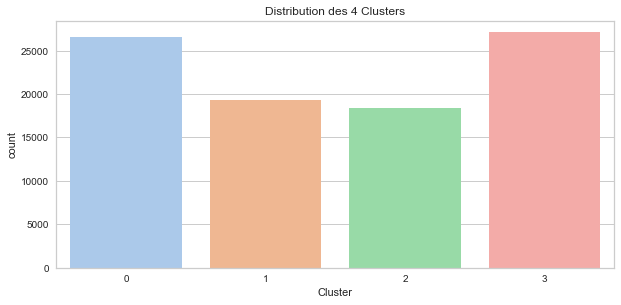

Text(0.5, 1.0, 'Distribution des 5 Clusters')

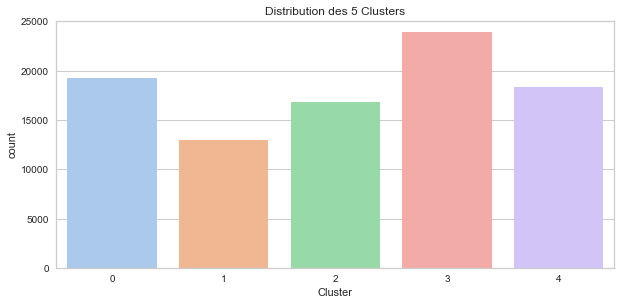

In [41]:
# Plotting countplot of clusters
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
pl = sns.countplot(x=df_k4["Cluster"], palette="pastel")
pl.set_title("Distribution des 4 Clusters")
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
pl = sns.countplot(x=df_k5["Cluster"], palette="pastel")
pl.set_title("Distribution des 5 Clusters")

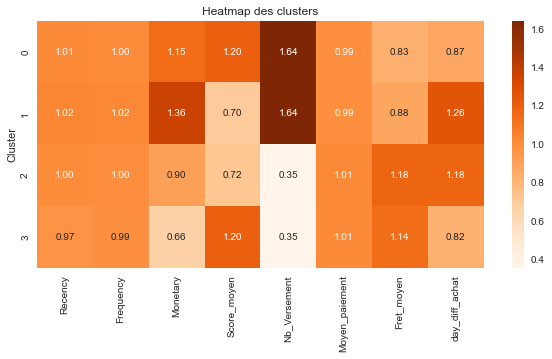

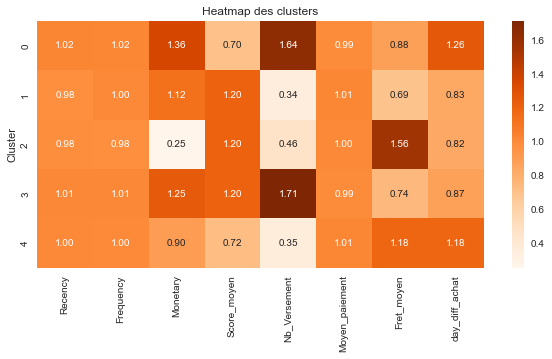

In [42]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
heatmap(df_k4)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
heatmap(df_k5)

- Interprétation métier des clusters: 

In [43]:
k_values(df_k5)

Recency Frequency Monetary Score_moyen Nb_Versement Moyen_paiement  \
            mean      mean     mean        mean         mean           mean   
Cluster                                                                       
0       244.0290    1.0510 288.9940      2.9080       4.7610         1.0120   
1       232.5140    1.0340 238.1370      4.9970       1.0000         1.0370   
2       233.2050    1.0080  53.2320      5.0000       1.3340         1.0270   
3       240.6960    1.0380 265.1720      5.0000       4.9710         1.0110   
4       238.4630    1.0280 190.0510      2.9950       1.0260         1.0360   

        Fret_moyen day_diff_achat         
              mean           mean  count  
Cluster                                   
0          18.2910        15.1370  19281  
1          14.3670         9.9880  12957  
2          32.5220         9.9180  16815  
3          15.4810        10.4770  23881  
4          24.6570        14.2090  18299

In [44]:
df_k5.mean()

Recency          238.4098
Frequency          1.0328
Monetary         212.2373
Score_moyen        4.1553
Nb_Versement       2.9011
Moyen_paiement     1.0228
Fret_moyen        20.8978
day_diff_achat    12.0378
Cluster            2.0982
dtype: float64

- Analyse métier des clusters : 

Clustering à 5 :

* **Cluster 0** : Le premier groupe contient 19281 clients . Ils ont fait les plus gros achats et sont plus fréquents et pourtant ne sont pas du tout satisfaits. Leur dernier achat remonte à  bien longtemps. Ils sont livrés très en retard et paient un coût de livraison assez élevé. Ils étalent leurs paiements sur plusieurs fois

- Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur(Clients que vous ne devez pas perdre)

* **Cluster 1** : Le deuxième groupe contient 12957 clients. Ils dépensent beacoup et paient en une fois. Ils sont livrés rapidement pour un coût bas de livraison. Ce sont des clients satisfaits.

- Proposez-leur de rejoindre votre programme de fidélité / membres. Recommandez-leur d’autres produits(Clients potentiellement fidèles)

* **Cluster 2** :  Ce groupe contient 16815 clients . Il Regroupe les clients qui dépensent le moins, ne paient pas sur plusieurs fois . Ils n'ont pas acheté depuis longtemps .Ils paient très cher leurs livraisons et sont livrés à temps .Les avis de ces clients sont également très bons.

- Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.(Clients en hibernation)

* **Cluster 3** : Ce groupe comporte 23881 clients.Ils paient sur plusieurs fois et c'est pour des montants assez élevés. Les avis de ces clients sont très bons. Ils sont livrés t dans un temps moyen et ne paient pas cher leurs livraisons.

- Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.(Clients fidèles)

* **Cluster 4** : Ce groupe comporte 18299 clients. Ils n'ont pas acheté récemment ne dépense pas beaucoup . Ils ne paient pas sur plusieurs fois . Ils sont livrés en retard et paient un coût de livraison élevé. Ils ne sont pas du tout satisfaits 

- Partagez-leur des ressources de valeur, recommandez-leur des produits populaires, des promotions sur leur renouvellement. Reconnectez avec eux.(Clients sur le point de s’endormir)

###  ACP : <a class="anchor" id="acp"></a>

- Cercle des corrélations : 
- Projection des individus selon clustering

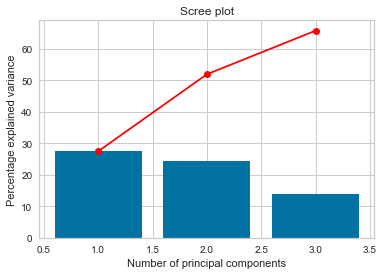

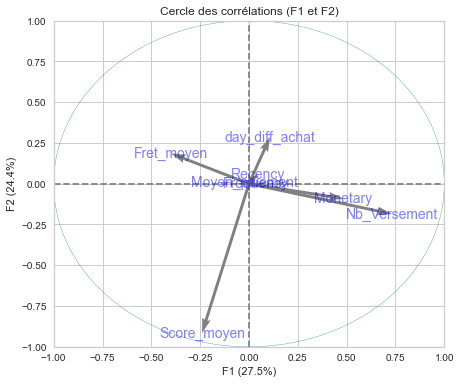

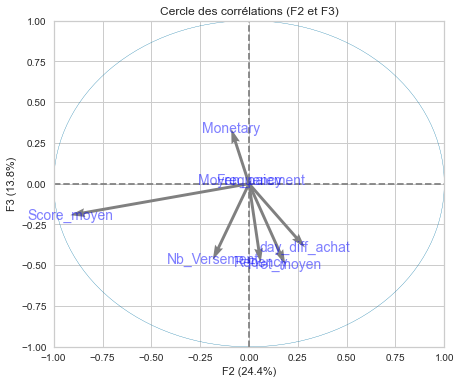

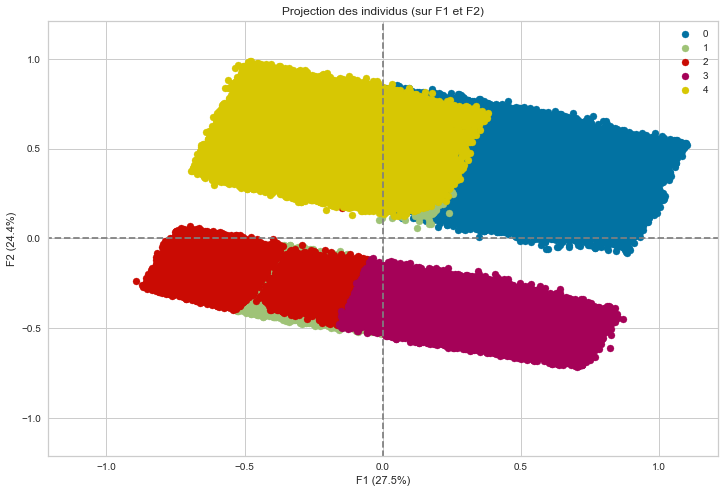

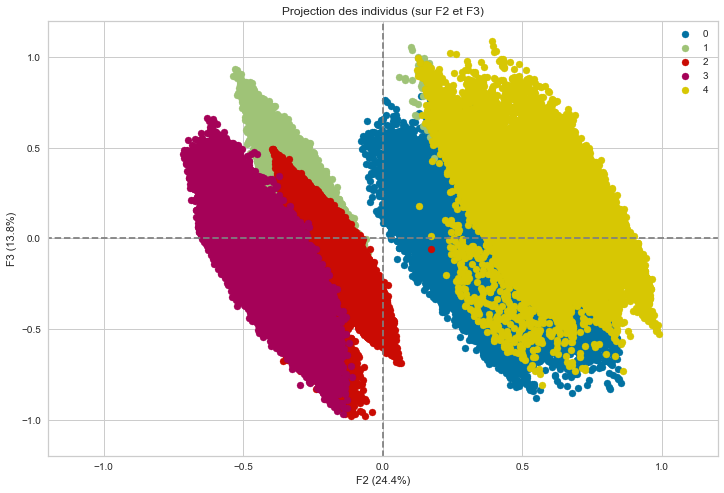

In [94]:
%matplotlib inline

# selection des colonnes à prendre en compte dans l'ACP

features = df_olist_2_scaled.iloc[:, 0:8].columns

# Calcul des composantes principales
# Select the number of principal components we will return
num_components = 3

# Create the PCA model
pca = PCA(n_components=num_components)
# Fit the model with the standardised data
pca.fit(df_olist_2_scaled.iloc[:, 0:8])

# Eboulis des valeurs propres pour choisir le nombre de compsantes
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0, 1), (1, 2)], labels=np.array(features))

# Projection des individus

X_projected = pca.transform(df_olist_2_scaled.iloc[:, 0:8])
display_factorial_planes(
    X_projected,
    n_comp,
    pca,
    [(0, 1), (1, 2), (2, 3)],
    labels=None,
    illustrative_var=df_k5["Cluster"],
)

plt.show()

###  DBSCAN : <a class="anchor" id="dbs"></a>

- Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale. On peut le diviser en 4 étapes : 

Pour chaque observation on regarde le nombre de points à au plus une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l’observation.
Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité. 
Toutes les observations au voisinage d’une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent de proche en proche on obtient une longue séquence d’observations cœur qui constitue un unique cluster. 
Toute observation qui n’est pas une observation cœur et qui ne comporte pas d’observation cœur dans son voisinage est considérée comme une anomalie. 

Rechercher ε optimal
C'est la distance la plus éloignée à laquelle un point choisira ses voisins. Par conséquent, intuitivement, cela décidera du nombre de voisins qu'un point découvrira. Bien que pour les min_points/min_samples nous puissions donner une valeur par défaut, nous ne pouvons pas le faire pour eps.

In [95]:
%%time
neigh= NearestNeighbors(n_neighbors=50)
nbrs= neigh.fit(df_olist_2_sample_scaled)
distances, indices = nbrs.kneighbors(df_olist_2_sample_scaled)

CPU times: user 3.46 s, sys: 22.4 ms, total: 3.48 s
Wall time: 3.48 s


In [96]:
distances

array([[0.        , 0.10940998, 0.17048607, ..., 0.3226463 , 0.32636744,
        0.32805832],
       [0.        , 0.06988219, 0.08743821, ..., 0.16209907, 0.16257591,
        0.16303537],
       [0.        , 0.05275525, 0.05403066, ..., 0.11529408, 0.11653282,
        0.11740863],
       ...,
       [0.        , 0.06599749, 0.06841221, ..., 0.14307163, 0.14368755,
        0.14527038],
       [0.        , 0.07587652, 0.07951745, ..., 0.14679279, 0.14728762,
        0.14911366],
       [0.        , 0.08716761, 0.12203493, ..., 0.24396209, 0.24483554,
        0.24651241]])

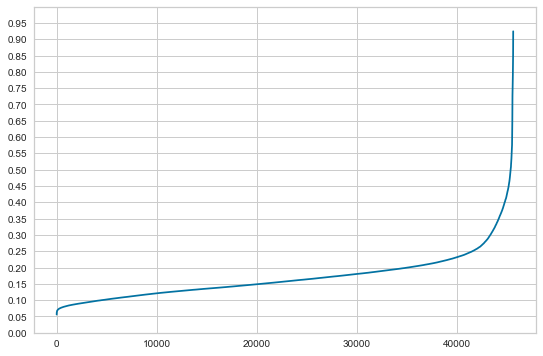

In [97]:
avg_dist= [d.mean() for d in distances]
avg_dist.sort()
plt.figure(figsize=(9,6))
plt.plot(list(range(df_olist_2_sample_scaled.shape[0])), avg_dist)
plt.ylim(0,1)
plt.yticks(np.arange(0,1,0.05))
plt.show()

Dans le diagramme de distance k-NN, vous devez rechercher le « coude » de la courbe pour trouver la valeur optimale de ε. 
Dans le graphique ci-dessous, le genou se produit à environ 0.8

In [98]:
clusters = DBSCAN(eps=0.8, min_samples=16).fit(df_olist_2_sample_scaled)
# get cluster labels
clusters.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
# check unique clusters
set(clusters.labels_)

{0, 1, 2, 3}

le DBSCAN indique 4 clusters

min_samples Échantillons minimum ("MinPts") : le plus petit nombre de points requis pour former un cluster
Plus l'ensemble de données est grand, plus la valeur de MinPts doit être élevée
Si l'ensemble de données est plus bruyant, chosir une valeur plus élevée de MinPts
Généralement, MinPts doit être supérieur ou égal à la dimensionnalité de l'ensemble de données

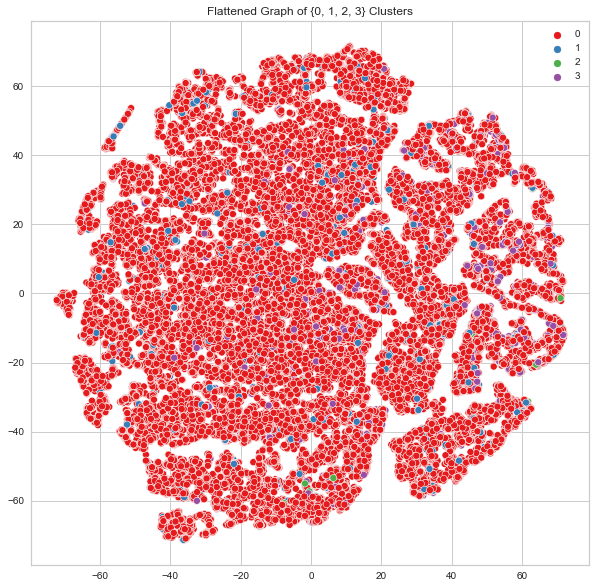

In [100]:
plt.figure(figsize=(10, 10))
df_dbscan = dbscan(df_olist_2_sample_scaled, 12, 0.8 ,df_olist_2_sample)

In [101]:
df_dbscan.groupby("Cluster")["Frequency","Recency","Monetary","Score_moyen","Nb_Versement",
                                   'Moyen_paiement','Fret_moyen','day_diff_achat'].mean()

Frequency  Recency  Monetary  Score_moyen  Nb_Versement  \
Cluster                                                            
0           1.0000 238.0123  208.1614       4.1472        2.9399   
1           1.0000 259.4985  205.1001       4.1049        1.7171   
2           2.1412 192.0471  378.8979       4.1539        2.3929   
3           2.1212 223.3461  500.8328       4.1964        3.3590   

         Moyen_paiement  Fret_moyen  day_diff_achat  
Cluster                                              
0                1.0000     20.8395         12.0716  
1                1.7437     21.2866         12.4669  
2                1.7306     23.0804         11.0637  
3                1.0000     21.4536         12.0754

Le dbscan n'a pas donné de bons résultats en terme de distinction métier des différents clusters

#### Evaluation de la stabilité du clustering Kmeans :  <a class="anchor" id="eva"></a>

- Tester la stabilité du clustering avec un Kmeans = 5

Text(0.5, 1.0, 'Inertie du Kmeans avec 5 clustering (Répétition à 10)')

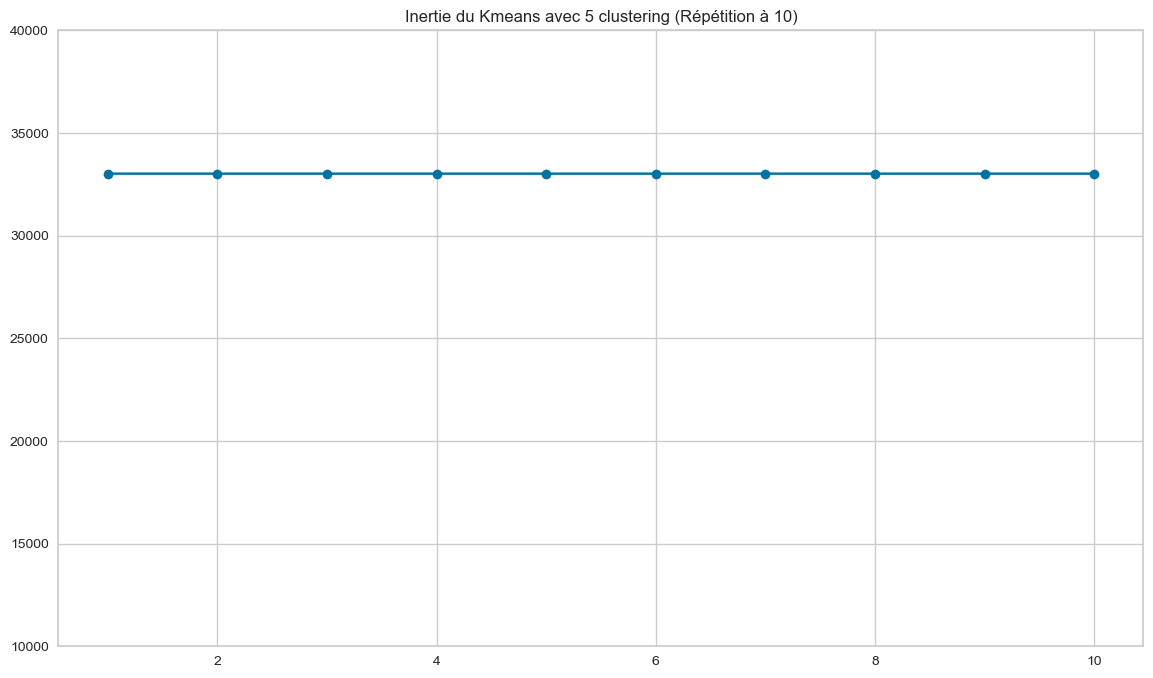

<IPython.core.display.Javascript object>

In [306]:
fig = plt.figure(1, figsize=(14, 8))

intertia = []

for k in range(1, 11):
    clus = KMeans(n_clusters=5, init="k-means++", max_iter=300)
    clus.fit(df_olist_2_scaled)
    inert = clus.inertia_
    intertia.append(inert)
plt.plot(range(1, 11), intertia, marker="o")
plt.ylim(10000, 40000)
plt.title("Inertie du Kmeans avec 5 clustering (Répétition à 10)")

In [312]:
intertia

[33017.26699667632,
 33017.45657486467,
 33017.349450336726,
 33017.26603416723,
 33017.24107228573,
 33017.24566516915,
 33017.289400327354,
 33017.252235255604,
 33017.24786412714,
 33017.3645130323]

<IPython.core.display.Javascript object>

Les différentes itérations montrent des inerties proches.

Tester la stabilité du clustering n en entrainant plusieurs fois le modèle sans fixer Random State.

Pour les labels true, je récupére les clusters calculés dans kmeans=5 puis je les compare avec ARI score pour chacune des itérations.

In [365]:
# clustering
model = KMeans(n_clusters=5, init="k-means++", max_iter=300)
model.fit(df_olist_2_scaled)
# Récupérer les lables
labels = model.labels_

array([3, 4, 0, ..., 2, 3, 3], dtype=int32)

<IPython.core.display.Javascript object>

In [379]:
def stabilite():
    clus = KMeans(n_clusters=5, init="k-means++", max_iter=300)
    clus = clus.fit(df_olist_2_scaled)
    Clus_pred = clus.labels_
    Clus_pred = metrics.adjusted_rand_score(Clus_pred, labels)
    return Clus_pred

<IPython.core.display.Javascript object>

In [381]:
score = []
for k in range(1, 11):
    Clus_pred = stabilite()
    score.append([k, Clus_pred])
# Résultat dans df
ari_scores = pd.DataFrame(score, columns=["Répétition", "ARI"])
ari_scores

Répétition    ARI
0           1 0.9977
1           2 0.9961
2           3 0.9959
3           4 0.9980
4           5 0.9958
5           6 0.9982
6           7 0.9974
7           8 0.9959
8           9 0.9962
9          10 0.9963

<IPython.core.display.Javascript object>

- Le résultat donne un score très proche de 1

### Conclusion : <a class="anchor" id="Conclusion"></a>

Grâce à la modélisation avec l’algorithme de Kmeans  nous avons  pu fournir aux équipes d'e-commerce une segmentation des clients Olist, qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
Une  proposition de contrat de maintenance basée sur l’ analyse de la stabilité des segments au cours du temps sera élaborée dans le prochain notebook